In [230]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

In [243]:
cascade_path = "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(cascade_path)
image_size = 100
emotions_dictionary = [None, "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

In [244]:
def extract_face(image):
    x, y, w, h = face_cascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=6
    )[0]
    
    face = image[y:y + h, x:x + w]
    resized_face = cv2.resize(face, (image_size, image_size))
    
    return resized_face

In [245]:
def images_emotions_data(participant_id, session_id):
    emotion_files = glob.glob('CK+/Emotion/{}/{}/*'.format(participant_id, session_id))
    if len(emotion_files) == 0:
        return [[], []]
    
    emotion_filename = emotion_files[0]
    with open(emotion_filename, 'r') as emotion_file:
        emotion = emotions_dictionary[int(float(emotion_file.read()))]
        
    if emotion == 'contempt' or emotion is None: # remove contempt
        return [[], []]

    session_images = sorted(glob.glob('CK+/cohn-kanade-images/{}/{}/*'.format(participant_id, session_id)))
    
    length = int(len(session_images) / 4)
    
    images = [session_images[-1 - i] for i in range(length)]
    data = (extract_face(cv2.imread(image, cv2.IMREAD_GRAYSCALE)).flatten() for image in images)
    
    return [data, [emotion for i in range(length)]]

In [246]:
participants = glob.glob("CK+/Emotion/*")

images = []
emotions = []

for participant in participants:
    # Get the participant ID from the last 4 chars
    participant_id = participant[-4:]

    sessions = glob.glob('{}/*'.format(participant))
    for session in sessions:
        # Get the participant ID from the last 4 chars
        session_id = session[-3:]
        
        current_image, current_emotion = images_emotions_data(participant_id, session_id)
        images += current_image
        emotions += current_emotion

In [247]:
X, y = np.array(images), np.array(emotions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2017)
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [248]:
sgd_clf = SGDClassifier(random_state=2017, max_iter=5)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=2017,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [249]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.92030848,  0.65374677,  0.85492228])

In [250]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_pred)

In [251]:
conf_matrix

array([[211,   3,   0,   1,   2,   0],
       [ 57, 111,   0,  11,   1,   0],
       [ 23,   2,  62,  19,   2,   6],
       [  5,   1,   0, 264,   0,   0],
       [ 72,   3,   2,   0,  34,   5],
       [  6,   0,   0,   0,   0, 259]])

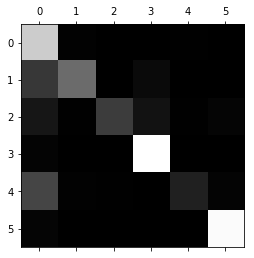

In [252]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)

In [254]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums

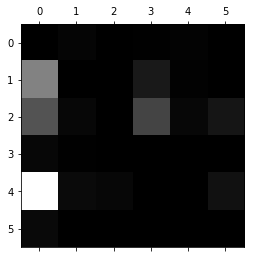

In [255]:
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.show()

In [256]:
sgd_clf.classes_

array(['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise'],
      dtype='<U8')

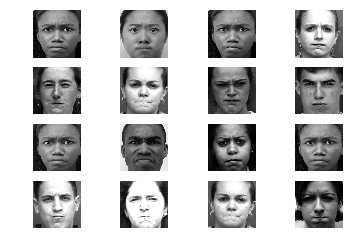

In [299]:
anger_as_sadness = [X_train[i] for i in range(len(X_train)) if y_train[i] == 'anger' and sgd_clf.predict([X_train[i]]) == 'sadness']

for i in range(16):
    face = anger_as_sadness[i]
    face.shape = (-1, image_size)
    plt.subplot(4, 4, i + 1)
    plt.imshow(face, cmap='gray')
    plt.axis('off')